In [1]:
import gym
import numpy as np
from agent import DLQAgent
from datetime import datetime
import sys
import json

Using TensorFlow backend.


In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

/Users/boniface/opt/miniconda3/envs/drlnd/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


State shape:  (8,)
Number of actions:  4


In [ ]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

In [5]:
class Config:
    def __init__(self):
        self.num_episodes = 500
        self.gamma = 0.99
        self.epsilon_start = 0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0
        self.tau = 1e-3
        self.memory_size = int(1e5)
        self.min_prioritization = 1e-4
        self.prioritization_exponent = 0
        self.prioritization_importance_sampling_start = 0
        self.prioritization_importance_sampling_end = 0
        self.batch_size = 64
        self.update_every = 10
        self.mlp_layers = (200, 150)
        self.learning_rate = 5e-4
        
        
    def as_dict(self):
        return self.__dict__

dlq_agent = DLQAgent(Config(), env.action_space.n, env.observation_space.shape[0])

In [8]:
def rolling_avg_scores(scores, window):
    if len(scores) <= window:
        return [np.mean(scores)]
    else:
        return [np.mean(scores[x:x+window]) for x in range(len(scores) - window + 1)]

def run(env, agent, num_episodes=1500):
    start_time = datetime.utcnow()
    scores = []
    health_checks = []
    for i_episode in range(num_episodes):
        state = env.reset()
        score = 0
        while True:
            action = agent.act(state)                      # select an action
            next_state, reward, done, _ = env.step(action) # send the action to the environment
            score += reward                                # update the score
            agent.step(
                state, action, next_state, reward, done)   # update the agent
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                scores.append(score)
                break
        health_check = agent.health_check()
        health_checks.append(health_check)
        model1_loss, memory_max_prioritization, memory_size = health_check
        print("\rEpisode %d/%d | Max Average Score: %.2f | Model 1 loss: %.2f | Memory max prioritization: %.2f | Memory size: %d" % (
            i_episode,
            num_episodes,
            max(rolling_avg_scores(scores, 20)),
            model1_loss,
            memory_max_prioritization,
            memory_size), end="")
        sys.stdout.flush()
    end_time = datetime.utcnow()
    return scores, end_time - start_time, health_checks

In [9]:
scores, run_timing, health_checks = run(env, dlq_agent, num_episodes=Config().num_episodes)
with open('training_log.txt', 'a') as file:
    file.write("Training run on %s \n" % datetime.utcnow().isoformat())
    file.write("Lasted %dmin%d \n" % (run_timing.seconds // 60, run_timing.seconds % 60))
    file.write(json.dumps(Config().as_dict(), indent=2))
    file.write("\nMax average score: %f\n\n" % max(rolling_avg_scores(scores, 20)))

Episode 499/500 | Max Average Score: -166.20 | Model 1 loss: 16.58 | Memory max prioritization: 1.00 | Memory size: 547242

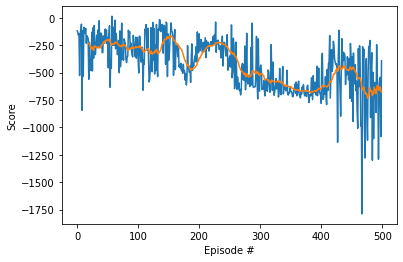

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(19, len(scores)), rolling_avg_scores(scores, 20))
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
from operator import itemgetter
losses = [x for x in map(itemgetter(0), health_checks)]
plt.plot(np.arange(len(losses)), losses)
plt.show()